In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.applications import InceptionV3

import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import pandas as pd
import cv2
import numpy as np

# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [ ]:
pip install -q --upgrade albumentations

     |████████████████████████████████| 113 kB 34.2 MB/s 
     |████████████████████████████████| 48.3 MB 1.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
my_path = 'MyDrive/CNN/MTARSI/'
fullpath = '/content/drive/' + my_path

# use $ symbol to use variable as path
%cd $fullpath

/content/drive/MyDrive/CNN/MTARSI


In [ ]:
csv_path = 'dirs_kfolds.csv'

df = pd.read_csv(csv_path)
df[:5]

,directories,labels,fold_idx
0,airplane-dataset-trans/A-10_Thunderbolt/15-70.jpg,0,2
1,airplane-dataset-trans/A-10_Thunderbolt/15-3.jpg,0,1
2,airplane-dataset-trans/A-10_Thunderbolt/15-36.jpg,0,2
3,airplane-dataset-trans/A-10_Thunderbolt/15-79.jpg,0,2
4,airplane-dataset-trans/A-10_Thunderbolt/15-50.jpg,0,2


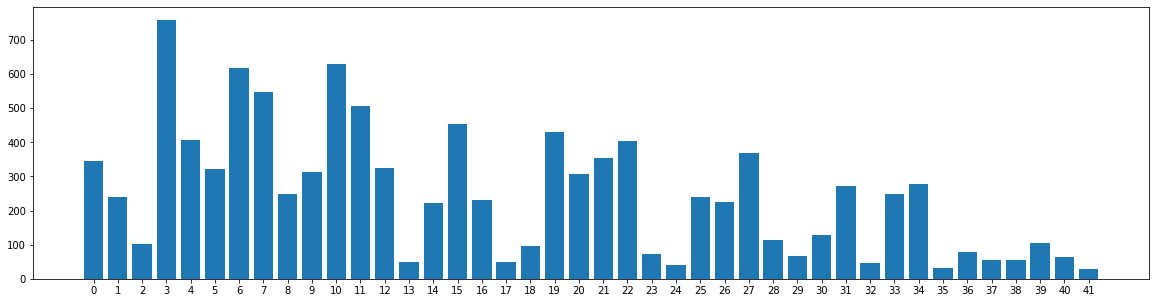

In [ ]:
value_counts = df['labels'].value_counts().sort_index()

plt.figure(figsize = (20,5))
plt.tight_layout()

plt.bar(range(len(value_counts)), value_counts.values)
plt.xticks(range(len(value_counts)), value_counts.index.values)

plt.show()

In [ ]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    
    # base_model = EfficientNetB0(
    #     input_shape=input_shape,
    #     weights='imagenet',
    #     include_top=False,
    #     pooling='avg'
    # )

    base_model = InceptionV3(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
    
    x = base_model(inputs)
    output = layers.Dense(42, activation='softmax')(x)
    model = keras.Model(inputs, output)
    
    return model

In [ ]:
input_shape = (180, 180, 3)
model = get_model(input_shape)

Adam = keras.optimizers.Adam(lr=0.001) # Optional: RMSProp

model.compile(
    optimizer=Adam,
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 42)                86058     
                                                                 
Total params: 21,888,842
Trainable params: 21,854,410
Non-trainable params: 34,432
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([A.HorizontalFlip(p=0.6),
                                         A.ShiftScaleRotate(p=0.5,
                                                            shift_limit=0.05,
                                                            scale_limit=0.05,
                                                            rotate_limit=15,),
                                        A.CoarseDropout(p=0.5,
                                                        max_holes=8,
                                                        max_height=int(0.1 * size),
                                                        max_width=int(0.1 * size)),
                                        A.RandomBrightnessContrast(p=0.3),])
            
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [ ]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, 
                 batchSize, imgSize, foldIdx, csvPath, 
                 shuffle = True, mode = 'train'):
        
        self.df = pd.read_csv(csvPath)
        
        self.batch_size = batchSize
        self.img_size = imgSize
        self.fold_idx = foldIdx
        
        self.shuffle = shuffle
        self.mode = mode
        
        if self.mode == 'train':
            self.df = self.df[ self.df['fold_idx'] != self.fold_idx]
            
        elif self.mode == 'val':
            self.df = self.df[ self.df['fold_idx'] == self.fold_idx]
        
        self.transform = Augmentation(imgSize, mode)
        
        self.on_epoch_end()
    
    def __len__(self):
        # Overriding len() function
        # Returns number of batches
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        # Batch iteration

        # if batch_size = 2, 
        # start = 0 * 2 = 0
        # end = 0 + 1 * 2 = 2
        # 0 -> 2
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        
        data = self.df.iloc[start:end]
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data): # Returns images read and labels
        
        batch_x = [] # For images
        batch_y = [] # For labels
        
        for _, row in data.iterrows():
            file_name = row['directories']
            
            # Read, convert BGR image -> RGB, resize, then normalise.
            image = cv2.imread(f'{file_name}')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.img_size, self.img_size))

            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')
            image = image / 255.
            
            label = int(row['labels'])
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac = 1).reset_index(drop=True)

In [ ]:
# Args | DataGenerator(imgSize, foldIdx, csvPath, shuffle = True, mode = 'train')

train_generator = DataGenerator(foldIdx=1, mode='train', csvPath=csv_path, 
                                batchSize=128, imgSize=180, shuffle=True)

valid_generator = DataGenerator(foldIdx=1, mode='val',  csvPath=csv_path, 
                                batchSize=128,  imgSize=180,  shuffle=True)

In [ ]:
len(train_generator)

41

In [ ]:
# patience -> epochs
# if val_loss does not decrease for 3 epochs -> Stop learning.

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  verbose = 1, patience = 3, 
                                                  mode = 'min', restore_best_weights = False)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                         verbose = 1, patience = 10,
                                                         factor = 0.1, mode = 'min',
                                                         min_lr = 0.0001)

filepath = 'outputs/{epoch:02d}-{val_loss:.2f}.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                      monitor = 'val_loss', verbose = 1,
                                                      save_best_only = True, 
                                                      save_weights_only = False,
                                                      mode = 'min')

history = model.fit(train_generator, 
                    validation_data = valid_generator,
                    callbacks = [early_stopping, reduce_on_plateau, model_checkpoint], 
                                 epochs = 8, verbose = 1)

Epoch 1/8
41/41 [==============================] - ETA: 0s - loss: 2.3234 - accuracy: 0.4318 
Epoch 1: val_loss improved from inf to 2.02731, saving model to outputs/01-2.03.hdf5
41/41 [==============================] - 2988s 73s/step - loss: 2.3234 - accuracy: 0.4318 - val_loss: 2.0273 - val_accuracy: 0.5296 - lr: 1.0000e-04
Epoch 2/8
41/41 [==============================] - ETA: 0s - loss: 0.7431 - accuracy: 0.8019
Epoch 2: val_loss improved from 2.02731 to 0.69110, saving model to outputs/02-0.69.hdf5
41/41 [==============================] - 55s 1s/step - loss: 0.7431 - accuracy: 0.8019 - val_loss: 0.6911 - val_accuracy: 0.7827 - lr: 1.0000e-04
Epoch 3/8
41/41 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.9057
Epoch 3: val_loss improved from 0.69110 to 0.41577, saving model to outputs/03-0.42.hdf5
41/41 [==============================] - 73s 2s/step - loss: 0.3189 - accuracy: 0.9057 - val_loss: 0.4158 - val_accuracy: 0.8672 - lr: 1.0000e-04
Epoch 4/8
41/41 

In [ ]:
from tensorflow.keras.models import save_model

filepath = 'outputs_7/'
save_model(model, filepath)

INFO:tensorflow:Assets written to: outputs_7/assets


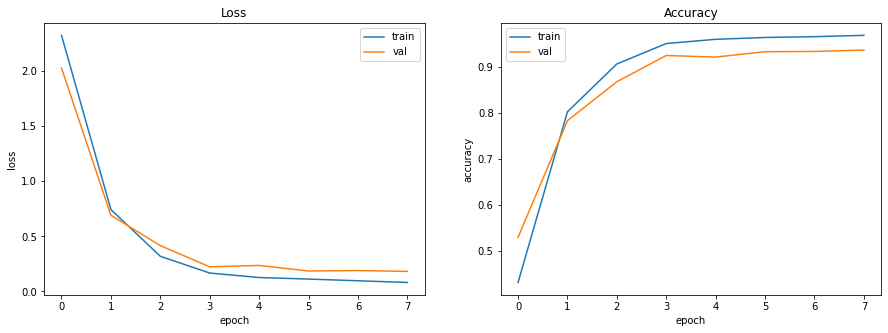

In [ ]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

In [ ]:
import os

def getClassNames(mainpath, getFullPath = False):
    
    # ========================= # 
    def findAirplanetitle(directory): # Nested function to find the last backslash of a directory (Airplane type name).
        
        slashes = [] # Will contain indices of backslahses in a directory address
    
        for i in range(len(directory)): # Find every backslash indices in a directory address
            if directory[i] == '/':
                slashes.append(i)
        
        return max(slashes) # Returns largest index integer 
    # ========================= # 
    
    planeList = [] # Will contain aircraft names
    fullpath = [] # Will contain full directory path
    
    folders = os.scandir(os.path.dirname(mainpath))
    
    for folder in folders:        
        backslash = findAirplanetitle(folder.path) # Find largest backslash index in a directory address
        title = folder.path[backslash + 1:]        
        planeList.append(title)
        
        if getFullPath:
            fullpath.append(folder.path)
    
    # Alphabetical order 
    planeList.sort()
    fullpath.sort()
    
    return planeList, fullpath
        
path = 'airplane-dataset-trans/'
class_names, _ = getClassNames(path)
print(class_names)

['A-10_Thunderbolt', 'ATR-72_Airliner', 'ATR_72_ASW', 'Airliner', 'B-1_Lancer', 'B-29_Superfortress', 'B-2_Spirit', 'B-52_Stratofortress', 'B-57_Canberra', 'BusinessJet', 'C-130_Hercules', 'C-135_Stratolifter', 'C-17_Globemaster', 'C-295M_CASA_EADS', 'C-40_Clipper', 'C-5_Galaxy', 'DC-4', 'DC-4E', 'E-2_Hawkeye', 'E-3_Sentry', 'EA-6B_Prowler', 'F-15_Eagle', 'F-16_Falcon', 'F-18_Hornet', 'F-22_Raptor', 'F-35_JSF', 'F-4_Phantom', 'KC-767_Tanker', 'King_Air_Beechcraft_Airliner', 'King_Air_Beechcraft_ISR', 'LightACHighSetWing', 'LightACLowSetWing', 'LightACTwinEnginProp', 'None', 'P-3_Orion', 'RC-135_Rivit_Joint', 'Su-37_Flanker', 'T-1A_Jayhawk_Trainer', 'T-43A_Boeing737-253A_Trainer', 'Tu-160_Tupolev_White_Swan', 'UTA_Fokker_50_Utility_Transport', 'Unknown']


In [ ]:
train_generator = DataGenerator(foldIdx=1, mode='train', csvPath=csv_path, 
                                                       batchSize=128, imgSize=180, shuffle=True)

In [ ]:
# for batch in train_generator:
#     X, y = batch
#     break

from tensorflow.keras.models import load_model

# Load the model
model = load_model('outputs_7/', compile = True)

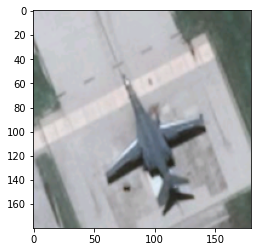

In [ ]:
# len(X) => 128

# image = X[np.random.randint(0, 128)]

# ======= Codes for outside of the training samples images
image = 'SAMPLE/guam.png'
image = cv2.imread(image)
# ======================================================

image = cv2.resize(image, (180, 180))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ======= Codes for outside of the training samples images
image = image.astype('float32')
image = image / 255.
# ======================================================

plt.imshow(image)
plt.show()

## try rotate -> get percentage per every rotation..

In [ ]:
rgb_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
image = tf.expand_dims(rgb_tensor , 0)

In [ ]:
# Generate predictions for samples
predictions = model.predict(image)
print("Predictions:", predictions, np.shape(predictions), '\n')

# Generate arg maxes for predictions
classes = np.argmax(predictions, axis = 1)
print("Class: {} -> The aircraft in the image is identified as {}. ".format(int(classes), class_names[int(classes)]))

Predictions: [[1.80205039e-04 2.77206651e-04 2.40308771e-04 4.39563126e-04
  8.80137563e-01 1.00956866e-04 1.77937001e-03 6.08396549e-05
  9.31453687e-05 6.66804553e-05 9.60325003e-02 1.98028958e-03
  1.87888055e-03 1.92089065e-04 1.25257077e-03 5.72303636e-03
  5.40353823e-04 2.41756032e-04 6.74914263e-05 9.52935079e-05
  3.04461224e-04 6.99597294e-05 4.29915171e-03 1.63805104e-04
  5.27289085e-05 1.30298125e-04 1.95606233e-04 4.78287926e-04
  1.33489346e-04 1.26211497e-04 2.45072995e-04 3.34435957e-04
  1.06862688e-04 1.64854391e-05 9.98552277e-05 2.73958023e-04
  7.67671736e-05 3.94523435e-04 4.42901044e-04 4.54211055e-04
  5.89712981e-05 1.61918186e-04]] (1, 42) 

Class: 4 -> The aircraft in the image is identified as B-1_Lancer. 


In [ ]:
import fnmatch

# Read only single, randomly chosen image from each airplane folder
def pickOneImgFromAFolder(path):
    samples = []
    dir_list= []

    directories = os.scandir(os.path.dirname(path))
    for dir in directories:
        dir_list.append(dir.path)
    
    dir_list.sort()

    for dir in dir_list:
        temp_list = []
        objects = os.scandir(os.path.dirname(dir + '/'))
        
        for obj in objects:
            if fnmatch.fnmatch(obj.path, "*.jpg") or fnmatch.fnmatch(obj.path, "*.png"):
                temp_list.append(obj.path)
      
        imgidx = np.random.randint(0, len(temp_list)) 
        samples.append(temp_list[imgidx])
    
    return samples

path = 'airplane-dataset-trans/'
samples = pickOneImgFromAFolder(path)
print(samples)

['airplane-dataset-trans/A-10_Thunderbolt/15-109.jpg', 'airplane-dataset-trans/ATR-72_Airliner/13-99 - Copy.jpg', 'airplane-dataset-trans/ATR_72_ASW/13-115.jpg', 'airplane-dataset-trans/Airliner/0-264.jpg', 'airplane-dataset-trans/B-1_Lancer/image (136).png', 'airplane-dataset-trans/B-29_Superfortress/20-73.jpg', 'airplane-dataset-trans/B-2_Spirit/2-419.jpg', 'airplane-dataset-trans/B-52_Stratofortress/image (105).png', 'airplane-dataset-trans/B-57_Canberra/19-15.jpg', 'airplane-dataset-trans/BusinessJet/12-65.jpg', 'airplane-dataset-trans/C-130_Hercules/5-254.jpg', 'airplane-dataset-trans/C-135_Stratolifter/6-275.jpg', 'airplane-dataset-trans/C-17_Globemaster/7-290.jpg', 'airplane-dataset-trans/C-295M_CASA_EADS/13-116.jpg', 'airplane-dataset-trans/C-40_Clipper/11-360.jpg', 'airplane-dataset-trans/C-5_Galaxy/image (296).png', 'airplane-dataset-trans/DC-4/5-13 - Copy.jpg', 'airplane-dataset-trans/DC-4E/5-360.jpg', 'airplane-dataset-trans/E-2_Hawkeye/9-207.jpg', 'airplane-dataset-trans/E

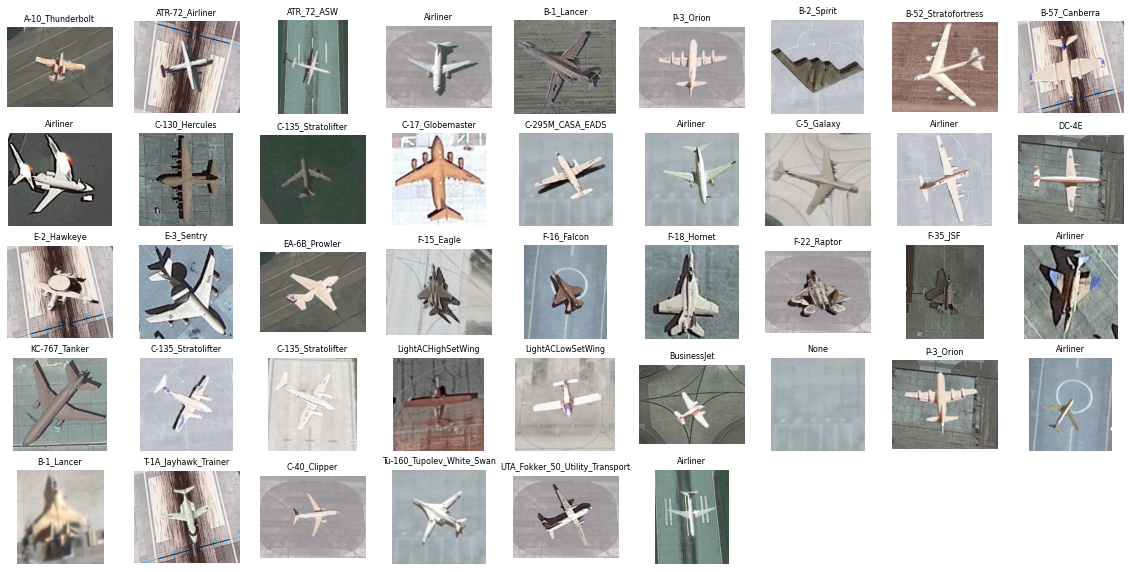

In [ ]:
# A Function to convert tensor to image
# import PIL 
# def tensor_to_image(tensor):
#     tensor = tensor*255
#     tensor = np.array(tensor, dtype=np.uint8)
#     if np.ndim(tensor)>3:
#         assert tensor.shape[0] == 1
#         tensor = tensor[0]
#     return PIL.Image.fromarray(tensor)


plt.figure(figsize = (20,10)) # figsize = (y_height, x_width)

def imageReader(image_path):
    pred = cv2.imread(image_path)
    image = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
    image = cv2.resize(pred, (180, 180))

    image = image.astype('float32')
    image = image / 255.
    
    rgb_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(rgb_tensor , 0)

    return image


def predict_img(image_path):
    classes = None
    predictions = None

    image = imageReader(image_path)

    predictions = model.predict(image)
    classes = np.argmax(predictions, axis = 1)

    result = class_names[int(classes)]
    return result


# Plot predicted images 
for idx, pred in enumerate(samples):
    plane_title = predict_img(pred)
    image_to_show = cv2.imread(pred)

    plt.subplot(5, 9, idx + 1)
    plt.imshow(image_to_show)
    plt.title(plane_title, fontsize=8)

    # axis('off) <- What happends if disabled?
    plt.axis('off')

# Confusion Matrix

In [ ]:
df_forCM = pd.read_csv(csv_path)
all_labels = []
all_samples_to_predict = []

In [ ]:
data = df_forCM.iloc[0:]

In [ ]:
data

,directories,labels,fold_idx
0,airplane-dataset-trans/A-10_Thunderbolt/15-70.jpg,0,2
1,airplane-dataset-trans/A-10_Thunderbolt/15-3.jpg,0,1
2,airplane-dataset-trans/A-10_Thunderbolt/15-36.jpg,0,2
3,airplane-dataset-trans/A-10_Thunderbolt/15-79.jpg,0,2
4,airplane-dataset-trans/A-10_Thunderbolt/15-50.jpg,0,2
...,...,...,...
10478,airplane-dataset-trans/Unknown/11-253.jpg,41,2
10479,airplane-dataset-trans/Unknown/13-27 - Copy.jpg,41,1
10480,airplane-dataset-trans/Unknown/13-27.jpg,41,2
10481,airplane-dataset-trans/Unknown/13-27 - Copy - ...,41,1


In [ ]:
import fnmatch

# Read only single, randomly chosen image from each airplane folder
def pickOneImgFromAFolder(path):
    samples = []
    dir_list= []

    directories = os.scandir(os.path.dirname(path))
    for dir in directories:
        dir_list.append(dir.path)
    
    dir_list.sort()

    for dir in dir_list:
        temp_list = []
        objects = os.scandir(os.path.dirname(dir + '/'))
        
        for obj in objects:
            if fnmatch.fnmatch(obj.path, "*.jpg") or fnmatch.fnmatch(obj.path, "*.png"):
                temp_list.append(obj.path)
      
        imgidx = np.random.randint(0, len(temp_list)) 
        samples.append(temp_list[imgidx])
    
    return samples

path = 'airplane-dataset-trans/'

In [ ]:
# Random?

for _, row in data.iterrows():
    label = int(row['labels'])
    all_labels.append(label)

    sample = row['directories']
    all_samples_to_predict.append(sample)

# all_samples_to_predict = pickOneImgFromAFolder(path)

In [ ]:
print("length, labels:", len(all_labels))
print("length, directories: ", len(all_samples_to_predict))

assert len(all_labels) == len(all_samples_to_predict)

length, labels: 10483
length, directories:  10483


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('outputs_7/', compile = True)

In [ ]:
def imageReader(image_path):
    pred = cv2.imread(image_path)
    image = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
    image = cv2.resize(pred, (180, 180))

    image = image.astype('float32')
    image = image / 255.
    
    rgb_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(rgb_tensor , 0)

    return image


def predict_img(image_path):
    classes = None
    predictions = None

    image = imageReader(image_path)

    predictions = model.predict(image)
    result = np.argmax(predictions, axis = 1)

    return result

In [ ]:
y_predicted_labels = []

In [ ]:
for predictionTargets in samples_to_predict:
    plane_integer_label = predict_img(predictionTargets)
    y_predicted_labels.append(plane_integer_label)

In [ ]:
cm = tf.math.confusion_matrix(labels= labels, predictions= y_predicted_labels)

Text(159.0, 0.5, 'Truth')

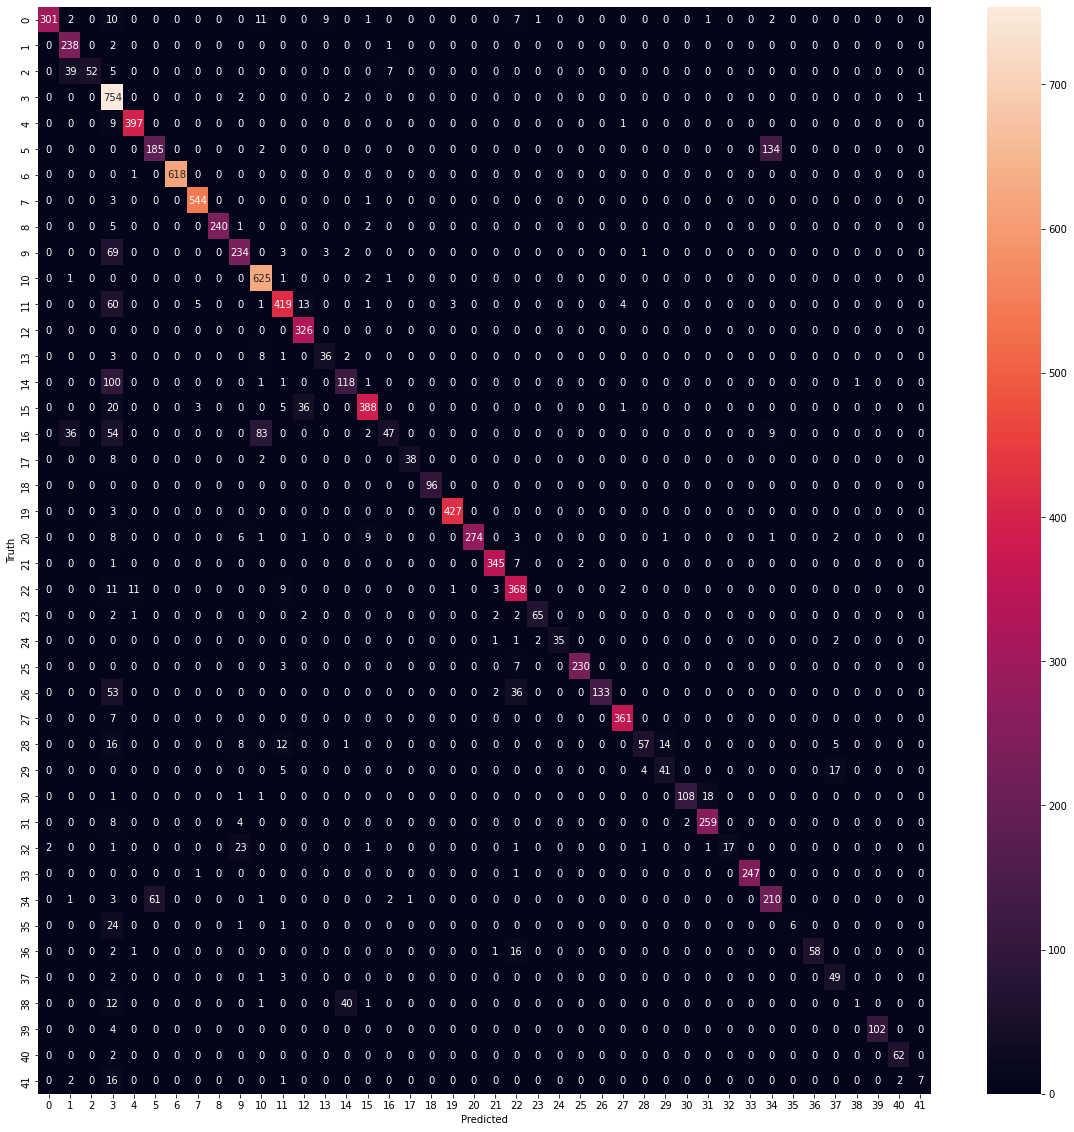

In [ ]:
import seaborn as sn

plt.figure(figsize = (20,20))
sn.heatmap(cm, annot=True, fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Truth')